In [2]:
import os
os.chdir('/Users/167011/Documents/MQF/Thesis/repo/')

import numpy as np
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import torch
import matplotlib.pyplot as plt

# Read in raw parquet
table = pq.read_table("/Users/167011/Documents/MQF/Thesis/Deribit_Data/deribit_options_2025-01-30_100k_rows.parquet")

# table = pq.read_table("/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet")


# Convert to pandas DataFrame
df = table.to_pandas()

# Seperate Option Type, Strike and Maturity
df[['asset', 'expiry', 'strike', 'option_type']] = df['instrument_name'].str.split('-', expand=True)

# Define maturity in years 'tau'
df['expiry'] = pd.to_datetime(df['expiry'])
reference_date = pd.to_datetime("2025-01-30")
df['tau'] = (df['expiry'] - reference_date).dt.days / 365.25 # Crypto is traded 24/7

# Filter for just calls and open_interest > 0 
df = df[(df['option_type'] == 'C') & (df['open_interest'] > 0)]

# Define mid price
df['mid_price'] = (df['best_bid_price'] + df['best_ask_price']) / 2

# Convert strike to numeric
df['strike'] = pd.to_numeric(df['strike'], errors = 'coerce')

# Define log moneyness, 'm'
df['m'] = np.log(df['strike'] / df['underlying_price'])

# # Choose tau grid based on Kmeans clustering

unique_taus = np.sort(df['tau'].unique()).reshape(-1,1)
# Finding different clusters of tau  (time to expiry)
tau_kmeans = KMeans(n_clusters=5, random_state=0).fit(unique_taus)
# Get the cluster centers and sort them
tau_grid = tau_kmeans.cluster_centers_.flatten()
# Assign each quote to a cluster
df['tau_cluster'] = tau_kmeans.predict(df[['tau']])

# Moneyness grid for each tau (ttm)
m_grid = {}
for cluster_label, tau in enumerate(tau_grid):
    # Select all rows in that clust
    subset = df[df['tau_cluster'] == cluster_label]
    # Get min and max m for that cluster
    m_lo, m_hi = np.percentile(subset['m'], [1, 99])
    m_grid[tau] = np.linspace(m_lo, m_hi, 10) # here we are assuming each moneyness point is equally likely

print(tau_grid)

for τi in tau_grid:
    print(f"τ={τi:.4f} → m_grid={m_grid[τi]}")


# Building the list of all (tau_i, m_ij) nodes
nodes = []
for tau in tau_grid:
    for m_j in m_grid[tau]:
        nodes.append((tau, m_j))
nodes = np.array(nodes) # Shape (N_nodes, 2)

# Fit to nearest neighbor model on those nodes
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(nodes)

# Query eachquote's (tau, m) to find the nearest node
points = df[['tau', 'm']].values # Shape (N_quotes, 2)
distances, indices = nn.kneighbors(points)



# Store back into dataframe
df['node_idx'] = indices[:, 0] # which row of 'nodes' it snapped too
df['lattice_tau']   = nodes[df['node_idx'], 0] # which tau it snapped too
df['lattice_m']     = nodes[df['node_idx'], 1] # which m it snapped too

# Within each time-slice, pick the most liquid quote per node:
best = (df
  .sort_values(['timestamp','node_idx','open_interest'],
               ascending=[True,True,False])
  .drop_duplicates(subset=['timestamp','node_idx']))

best = best[['timestamp', 'node_idx', 'lattice_tau', 'lattice_m', 'mid_price']]

best['timestamp'] = pd.to_datetime(best['timestamp'])

# Pivot to get a sparse lattice DataFrame (NaNs left in place)
C_sparse = best.pivot(
    index = 'timestamp',
    columns = 'node_idx',
    values = 'mid_price'
)

# Mask zeros as NaN so interpolation will fill them
C_sparse = C_sparse.replace(0, np.nan)

# Interpolate in time, then forward- and back-fill any edge NaNs
C_interp = (
    C_sparse
    .interpolate(method='linear', axis=0)  # linear interpolation along timestamps
    .ffill()                              # carry last valid forward
    .bfill()                              # fill any leading NaNs at the start
)




[0.11772758 0.90349076 0.40520192 0.65434634 0.01423682]
τ=0.1177 → m_grid=[-1.66369817 -1.36349295 -1.06328773 -0.76308251 -0.46287729 -0.16267207
  0.13753315  0.43773837  0.73794358  1.0381488 ]
τ=0.9035 → m_grid=[-1.75333077 -1.42006121 -1.08679164 -0.75352208 -0.42025252 -0.08698296
  0.24628661  0.57955617  0.91282573  1.2460953 ]
τ=0.4052 → m_grid=[-1.69696503 -1.36384192 -1.03071881 -0.69759569 -0.36447258 -0.03134947
  0.30177365  0.63489676  0.96801987  1.30114299]
τ=0.6543 → m_grid=[-1.7256284  -1.39235929 -1.05909018 -0.72582107 -0.39255196 -0.05928285
  0.27398627  0.60725538  0.94052449  1.2737936 ]
τ=0.0142 → m_grid=[-1.24073718 -1.04231579 -0.84389441 -0.64547302 -0.44705164 -0.24863025
 -0.05020887  0.14821252  0.34663391  0.54505529]


/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_30248/3084455193.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


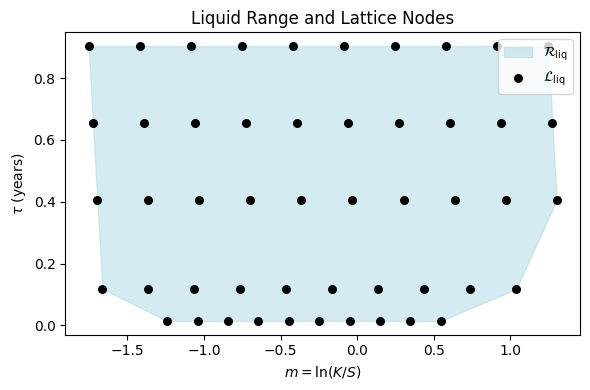

In [45]:
# 1) sort tau→m_grid
sorted_items = sorted(m_grid.items(), key=lambda kv: kv[0])
taus_s, m_ranges = zip(*sorted_items)
m_lo_s = np.array([rng.min() for rng in m_ranges])
m_hi_s = np.array([rng.max() for rng in m_ranges])

# 2) plot
plt.figure(figsize=(6,4))
plt.fill_betweenx(taus_s, m_lo_s, m_hi_s,
                  color='lightblue', alpha=0.5,
                  label=r'$\mathcal{R}_{\rm liq}$')

# scatter all nodes if you like
all_nodes = np.vstack([
    np.column_stack([m_grid[t], np.full_like(m_grid[t], t)])
    for t in taus_s
])
plt.scatter(all_nodes[:,0], all_nodes[:,1],
            color='k', s=30, label=r'$\mathcal{L}_{\rm liq}$')

plt.xlabel(r'$m = \ln(K/S)$')
plt.ylabel(r'$\tau$ (years)')
plt.title('Liquid Range and Lattice Nodes')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



In [35]:
print(np.sort(tau_grid))

[0.00752909 0.04106776 0.07939767 0.15605749 0.40520192 0.65434634
 0.90349076]


(array([6., 1., 0., 0., 1., 0., 0., 1., 0., 1.]),
 array([0.        , 0.09034908, 0.18069815, 0.27104723, 0.3613963 ,
        0.45174538, 0.54209446, 0.63244353, 0.72279261, 0.81314168,
        0.90349076]),
 <BarContainer object of 10 artists>)

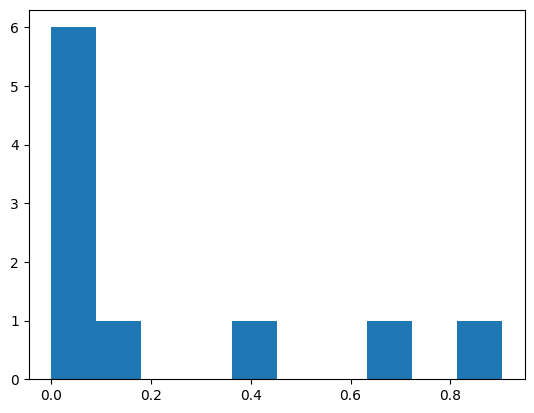

In [29]:
plt.hist(unique_taus)

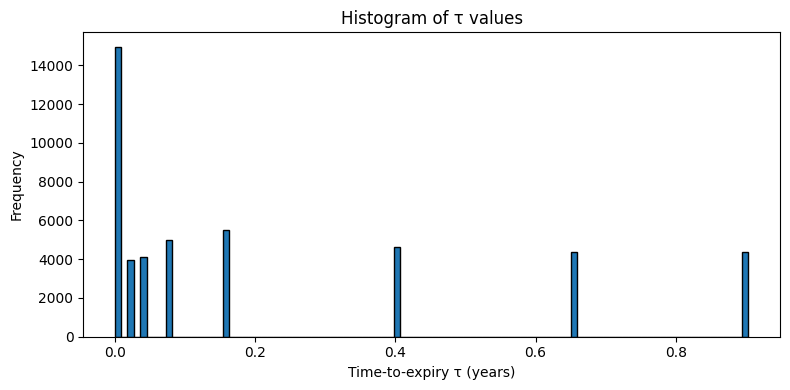

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df['tau'], bins=100, edgecolor='k')
plt.xlabel('Time-to-expiry τ (years)')
plt.ylabel('Frequency')
plt.title('Histogram of τ values')
plt.tight_layout()
plt.show()

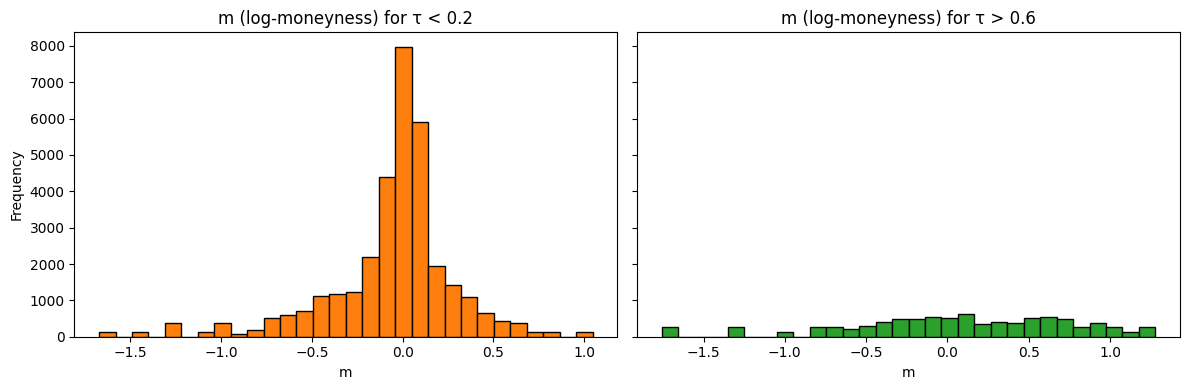

In [28]:
# plot histograms of m for two τ‐ranges
import matplotlib.pyplot as plt

m_lowτ  = df.loc[df['tau'] < 0.2, 'm']
m_highτ = df.loc[df['tau'] > 0.6, 'm']

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

axes[0].hist(m_lowτ,  bins=30, edgecolor='k', color='C1')
axes[0].set_title('m (log-moneyness) for τ < 0.2')
axes[0].set_xlabel('m')
axes[0].set_ylabel('Frequency')

axes[1].hist(m_highτ, bins=30, edgecolor='k', color='C2')
axes[1].set_title('m (log-moneyness) for τ > 0.6')
axes[1].set_xlabel('m')

plt.tight_layout()
plt.show()

Epoch 1/100  Train NLL: -3.3047e+00  Test NLL: -4.2624e+00
Epoch 2/100  Train NLL: -4.3161e+00  Test NLL: -4.3437e+00
Epoch 3/100  Train NLL: -4.3668e+00  Test NLL: -4.3578e+00
Epoch 4/100  Train NLL: -4.4048e+00  Test NLL: -4.4070e+00
Epoch 5/100  Train NLL: -4.4504e+00  Test NLL: -4.5015e+00
Epoch 6/100  Train NLL: -4.4541e+00  Test NLL: -4.4926e+00
Epoch 7/100  Train NLL: -4.4746e+00  Test NLL: -4.4803e+00
Epoch 8/100  Train NLL: -4.4791e+00  Test NLL: -4.4884e+00
Epoch 9/100  Train NLL: -4.4909e+00  Test NLL: -4.5049e+00
Epoch 10/100  Train NLL: -4.4924e+00  Test NLL: -4.4367e+00
Epoch 11/100  Train NLL: -4.4987e+00  Test NLL: -4.4669e+00
Epoch 12/100  Train NLL: -4.5083e+00  Test NLL: -4.4796e+00
Epoch 13/100  Train NLL: -4.5060e+00  Test NLL: -4.4891e+00
Epoch 14/100  Train NLL: -4.5215e+00  Test NLL: -4.4576e+00
Epoch 15/100  Train NLL: -4.5094e+00  Test NLL: -4.5328e+00
Epoch 16/100  Train NLL: -4.5158e+00  Test NLL: -4.5060e+00
Epoch 17/100  Train NLL: -4.5277e+00  Test NLL: -

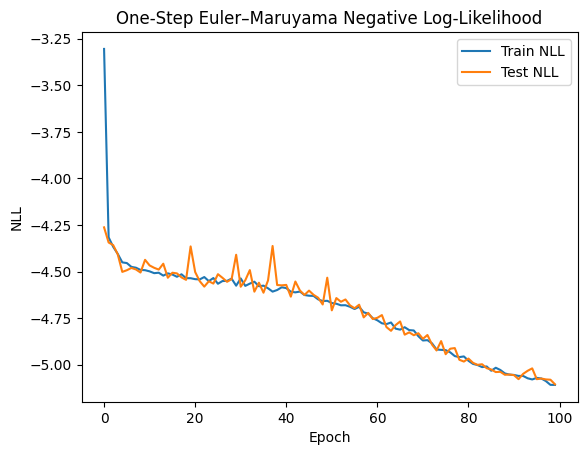

In [46]:
surf_arr = C_interp.to_numpy()              # or C.values
# print(surf_arr)
surf_tensor = torch.from_numpy(surf_arr).float()

import torch
import torch.nn as nn
import torch.optim as optim
import torchsde
import numpy as np
import math
import matplotlib.pyplot as plt

# 1) Load the BTC surface tensor
surf = torch.load("btc_surfaces.pt")  # shape [T, N]
T, N = surf.shape

# Load dt tensor
dt_tensor = torch.load('dt.pt')

# 2) Train/Test split (80/20)
split = int(T * 0.8)
surf_train = surf[:split]
surf_test = surf[split:]

device = "cuda" if torch.cuda.is_available() else "cpu"
surf_train = surf_train.to(device)
surf_test = surf_test.to(device)

# align dt
dt_train = dt_tensor[:split].to(device)
dt_test = dt_tensor[split:].to(device)

# Define dt pairs for each surface
dt_train_pairs = dt_train[1:].view(-1, 1)
dt_test_pairs = dt_test[1:].view(-1, 1)


# 3) Define the neural SDE on R^N
class SurfaceSDE(torchsde.SDEIto):
    def __init__(self, dim):
        super().__init__(noise_type="diagonal")
        # Drift network
        self.f_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
        # Diffusion network (output ≥ 0)
        self.g_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
            nn.Softplus()
        )

    def f(self, t, y):
        return self.f_net(y)

    def g(self, t, y):
        return self.g_net(y)

model = SurfaceSDE(N).to(device)

# 4) Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100
batch_size = 60


train_losses = []
test_losses = []

# 5) Training loop with likelihood-based loss
for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(split - 1)
    epoch_loss = 0.0

    for idx in perm.split(batch_size):
        y0 = surf_train[idx]       # [batch_size, N]
        y1 = surf_train[idx + 1]   # next step
        # Compute drift and diffusion
        drift = model.f(0, y0)     # [batch_size, N]
        diff = model.g(0, y0)      # [batch_size, N]
        # Compute increments
        dy = y1 - y0
        dt = dt_train_pairs[idx]   # [batch_size, 1]
        
        var = (diff ** 2) * dt + 1e-6  # variance per coordinate
        # Negative log-likelihood per coordinate
        nll = 0.5 * ((dy - drift * dt)**2 / var + torch.log(2 * math.pi * var))
        loss = nll.mean()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        epoch_loss += loss.item() * y0.size(0)

    train_loss = epoch_loss / (split - 1)
    train_losses.append(train_loss)

    # 6) Evaluate on test one-step
    model.eval()
    with torch.no_grad():
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        dt = dt_test_pairs
        drift_t = model.f(0, y0_test)
        diff_t = model.g(0, y0_test)
        dy_t = y1_test - y0_test
        var_t = (diff_t ** 2) * dt + 1e-6
        nll_t = 0.5 * ((dy_t - drift_t * dt)**2 / var_t + torch.log(2 * math.pi * var_t))
        test_loss = nll_t.mean().item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs}  Train NLL: {train_loss:.4e}  Test NLL: {test_loss:.4e}")

# 7) Plot training and test NLL curves
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()

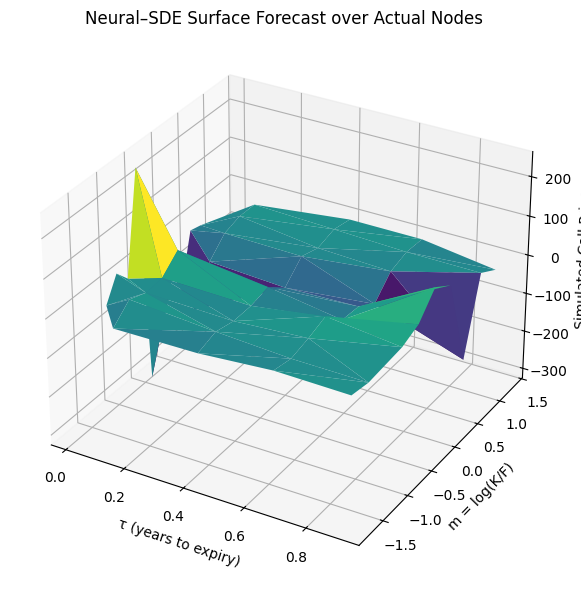

In [52]:
import numpy as np
import torch
import torchsde
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# ─── Assumptions ───────────────────────────────────────────────────────────────
# You have in memory (or have reloaded):
#   surf_tensor: torch.Tensor of shape [T, N]
#   dt_tensor:   torch.Tensor of shape [T]
#   C_interp:    pd.DataFrame of shape [T, N] with columns = node_idx integers
#   nodes:       np.ndarray of shape [N_all, 2], where nodes[k] = (tau, m)
#   model:       your trained SurfaceSDE instance
#   device:      torch.device("cuda") or torch.device("cpu")

# 1) Identify which (τ, m) pairs actually survived into C_interp
col_idx       = C_interp.columns.to_numpy()    # e.g. array of length N_present
nodes_present = nodes[col_idx]                 # shape (N_present, 2)

# 2) Simulate one trajectory of your SDE starting from the first surface
y0      = surf_tensor[0].to(device)            # [N_present]
dt_mean = dt_tensor.mean().item()              # average Δt

n_steps = 50
ts      = torch.linspace(0.0, n_steps*dt_mean, steps=n_steps+1, device=device)

# -> ys: [len(ts), N_present]
ys = torchsde.sdeint(
    model,
    y0.unsqueeze(0),
    ts,
    method="euler",
    dt=dt_mean
).squeeze(1)

# 3) Prepare data for triangulation plot
#    xi = τ coordinates, yi = m coordinates, zi = simulated price
xi = nodes_present[:, 0]
yi = nodes_present[:, 1]
zi = ys[-1].cpu().detach().numpy()   # final time-step

triang = mtri.Triangulation(xi, yi)

# 4) Plot the surface over the actual (τ, m) points
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection="3d")

ax.plot_trisurf(
    triang,
    zi,
    cmap="viridis",
    edgecolor="none",
    linewidth=0
)

ax.set_xlabel("τ (years to expiry)")
ax.set_ylabel("m = log(K/F)")
ax.set_zlabel("Simulated Call Price")
ax.set_title("Neural–SDE Surface Forecast over Actual Nodes")
plt.tight_layout()
plt.show()



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

# — Assumes in memory (or reloaded) —
# surf_tensor: torch.Tensor [T, N_present]
# C_interp:    pd.DataFrame [T, N_present] columns = node_idx ints
# nodes:       np.ndarray [N_all, 2]
# device:      torch.device
# (You do NOT need the trained model here.)

# 1) Figure out which nodes survived into your pivoted lattice
col_idx       = C_interp.columns.to_numpy()    # e.g. length N_present
nodes_present = nodes[col_idx]                 # shape (N_present, 2)
taus_p = nodes_present[:,0]
ms_p   = nodes_present[:,1]

# 2) Choose a timestamp index to visualize
t0_idx = 0   # for the very first snapshot; you can pick any 0 <= t0_idx < T
y_obs  = surf_tensor[t0_idx].cpu().numpy()  # shape (N_present,)

# 3) Triangulate the irregular grid
tri = mtri.Triangulation(taus_p, ms_p)

# 4) Plot the observed lattice surface
fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(
    tri, y_obs,
    linewidth=0.2, antialiased=True
)

ax.set_xlabel('τ (years to expiry)')
ax.set_ylabel('m = log(K/F)')
ax.set_zlabel('Observed Call Price')
ax.set_title(f'Liquid Lattice Surface at t₀ (index={t0_idx})')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [67]:
import torch
import torchsde
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri

# Assumes you've already loaded/reloaded:
# surf_tensor: [T, N_present] tensor
# dt_tensor:   [T] tensor
# C_interp:    DataFrame with columns = node_idx ints
# nodes:       ndarray shape [N_all, 2]
# model:       trained SurfaceSDE instance
# device:      torch.device

# 1) Which nodes survived?
col_idx       = C_interp.columns.to_numpy()    # length N_present
nodes_present = nodes[col_idx]                 # shape (N_present, 2)

# 2) Simulate one path
y0      = surf_tensor[0].to(device)            # [N_present]
dt_mean = dt_tensor.mean().item()
ts      = torch.linspace(0.0, 50*dt_mean, 51, device=device)

ys = torchsde.sdeint(
    model,
    y0.unsqueeze(0),
    ts,
    method="euler",
    dt=dt_mean
).squeeze(1)  # → [51, N_present]

# Extract final surface
xi = nodes_present[:, 0]
yi = nodes_present[:, 1]
zi = ys[-1].cpu().detach().numpy()

# Triangulate for irregular (τ,m) nodes
tri = mtri.Triangulation(xi, yi)

# 3) Plot with interactive matplotlib 3D
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

# plot_trisurf uses default colors
ax.plot_trisurf(tri, zi)

ax.set_xlabel('τ (years to expiry)')
ax.set_ylabel('m = log(K/F)')
ax.set_zlabel('Simulated Call Price')
ax.set_title('Interactive Neural-SDE Surface Forecast')

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>